# 4.1 Baseline
The Bradley-Terry model implies a Consensus Ranking based on the strength value of the players. I have mentioned (in my thesis) that Elo has a unique stationary distribution. This means that the ranking state over a long time is independent of the initial condition. It should ’always’ reach a state similar to the consensus ranking. I present simple RSTT simulations to assert whether kendalltau rank correlation is a menaingfull metric to study steady states of rankings. 

## Paramterers 

- *Player* 64 players of constant skill draw from a Gaussian distribution X ∼ N (μ = 1500, σ2 = 500) .
- *Game mode* one-versus-one.
- *Solver* The LogSolver() with a default base = 10 and logistic constant lc = 400. It computes win
probability
$$P(A\; beats\; B)= \dfrac{1}{base^{\dfrac{-(A.level()-B.level())}{lc}}}$$
- *Ranking* The Elo rating system with K = 20, lc = 400 and default rating 1500.
- *Scheduler* It is a comparative run where the scheduler is the varying parameter.
- *Interaction* RSSC loop described below. depth=160.

In [1]:
import random
from functools import partial

from rstt import BasicPlayer, BasicElo, BTRanking, LogSolver
from rstt import SingleEliminationBracket as SEB
from rstt import DoubleEliminationBracket as DEB
from rstt import RoundRobin, SwissRound, Snake


# Players
nb = 64
population = BasicPlayer.create(nb=64, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})

# Solver
solver = LogSolver(base=10, lc=400)

# Test Ranking
ELO = partial(BasicElo, k=20, lc=400, default=1500)

# Sheduler
schedulers = [RoundRobin, SwissRound, SEB, DEB, Snake]

# Interaction
depth = int(2.5 * nb) # 160 if nb==64

# Ground-Truth
gt = BTRanking('Consensus', population)
gt.plot()

----------- Consensus -----------
   0.        Kristi Walson       2525
   1.            John Zook       2384
   2.        Patty Woodman       2144
   3.         Marta Mohler       2140
   4.     Frances Phillips       2131
   5.      Geraldine Cohen       2033
   6.        Ronald Garcia       2031
   7.         Sandra Beets       2002
   8.        Joetta Decarr       1983
   9.         Murray Mason       1968
  10. Reginald Fitzpatrick       1915
  11.    Melissa Samaniego       1893
  12.         Jorge Ingram       1879
  13.          Gary Bailey       1837
  14.        Michael Lamke       1829
  15.         Nettie Mccaw       1825
  16.       Antonio Brooks       1811
  17.          Brian Heath       1793
  18.       William Molina       1715
  19.    Abraham Arrington       1713
  20.      Steven Gonnella       1701
  21.        Joshua Porter       1678
  22.           Luis Arias       1648
  23.      Kelsey Robinson       1636
  24.          Lynn Guzman       1624
  25.         Da

## Experimentation


### Protocol
The way all these objects interact with each other in the simulation is defined in by the RSSC loop. It is a function that takes as input a tuple (ranking R, scheduler C, solver S, depth D) and outputs a dataset. All players in the ranking are registered in competition C and seeded by ranking R. The scheduler C generates games. The games are assigned a result by the solver S. Then the games are used by R to update the ratings of all involved players. This is repeated ’D’ time.

### Scenario
Different initial conditions.
- (A) is the best case scenario, when the ranking knows in advance the ground truth.
- (B) is the normal case, where the ranking has no prior knowledge and all players have the same initial ratings of 1500.
- (C) shows a worst-case scenario, the player at rank i in the consensus ranking is assigned an Elo value equal to the strength of the player at rank n-i, where n is the number of players.

### Metric


In [2]:
from typing import Callable, Any
from scipy import stats

from rstt.stypes import Solver
from rstt import Ranking, Competition

# protocol
def rssc(name: str, seed: Ranking, cup: Competition, solver: Solver, depth: int,
         metric: Callable[[Ranking, Competition], Any], update: bool = True) -> list[Any]:
    results = []
    for i in range(depth):
        tournament = cup(f'{name} - rscc edition {i}', seed, solver)
        tournament.registration(seed.players())
        tournament.run()
        seed.update(event=tournament)
        results.append(metric(ranking=seed, event=tournament))
    return results    

# scenarios
def perfect_state(model: type[Ranking], ref: Ranking, name: str) -> Ranking:
    ranking = model(name, players=ref.players())
    for p in ref:
        ranking.set_rating(p, ref.rating(p))
    return ranking

def reverse_state(model: type[Ranking], ref: Ranking, name: str) -> Ranking:
    ranking = perfect_state(model, ref, name)
    #rank.rerank(list(range(len(gt)-1,-1, -1)))
    ranking.rerank(list(range(len(gt)))[::-1])
    return ranking

def initial_states(ranking: type[Ranking], ref: Ranking) -> list[Ranking]:
    return [
    perfect_state(ranking, gt, '(A) Groundtruth State'),
    ranking('(B) Standard State', players=gt.players()),
    reverse_state(ranking, gt, '(C) Reverse State'),
    ]

# metrics 
def ktcorr(ranking: Ranking, gt: Ranking, *args, **kwargs) -> float:
    return stats.kendalltau([gt.point(p) for p in gt],
                            [ranking.point(p) for p in gt])[0]

eva = partial(ktcorr, gt=gt)

In [3]:

results = {}
for scheduler in schedulers:
    results[scheduler.__name__] = {}
    for state in initial_states(ELO, gt):
        print(scheduler.__name__, state.name)
        results[scheduler.__name__][state.name] = [ktcorr(state, gt)]
        results[scheduler.__name__][state.name] += rssc('state.name', state, scheduler, solver, depth, eva)

RoundRobin (A) Groundtruth State
RoundRobin (B) Standard State
RoundRobin (C) Reverse State
SwissRound (A) Groundtruth State
SwissRound (B) Standard State
SwissRound (C) Reverse State
SingleEliminationBracket (A) Groundtruth State
SingleEliminationBracket (B) Standard State
SingleEliminationBracket (C) Reverse State
DoubleEliminationBracket (A) Groundtruth State
DoubleEliminationBracket (B) Standard State
DoubleEliminationBracket (C) Reverse State
Snake (A) Groundtruth State
Snake (B) Standard State
Snake (C) Reverse State


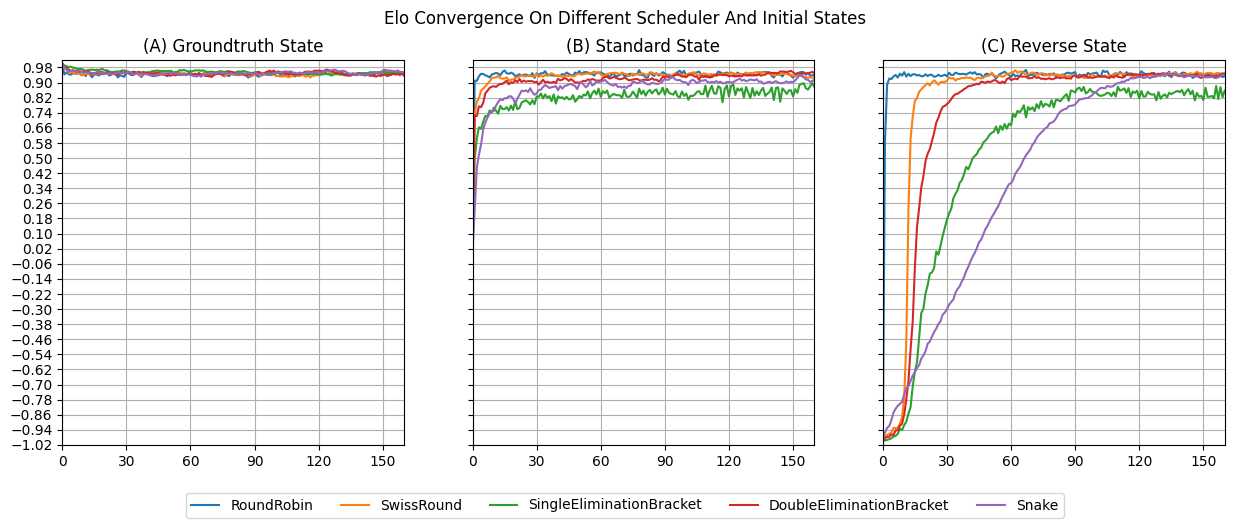

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

titles = list(set([ranking for k, v in results.items() for ranking in v.keys()]))
titles.sort()
datasets = {exp: {k: data for k, v in results.items() for ranking, data in v.items() if ranking == exp} for exp in titles}
x = list(range(0, depth+1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
for ax, scenario in zip(axs, titles):
    for scheduler, line in datasets[scenario].items():
        # adjust nan from 'flat ranking'
        if math.isnan(line[0]):
            line[0] = 0.0
        ax.plot(x, line, label=scheduler)
        ax.set_title(scenario)
        ax.set(xlim=(0, depth), xticks=np.arange(0, depth, 30),
               ylim=(-1.02, 1.02), yticks=np.arange(-1.02, 1.02, 0.08))
        ax.grid(True, axis='both')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=6, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Elo Convergence On Different Scheduler And Initial States')
plt.show()

## Figure 4.1

Behavior of Elo regarding different tournament formats, and different initial conditions. (A) is the best case scenario, when the ranking knows in advance the ground truth. (B) is the normal case, where the ranking has no prior knowledge and all players have the same initial ratings of 1500. (C) shows a worst-case scenario, the player at rank i in the consensus ranking is assigned an Elo value equal to the strength of the player at rank n-i, where n is the number of players.

## Conclusion

Kendalltau rank correlation with the consensus raning is a meaningfull metric regarding the convergence of the Elo system.